In [1]:

# utilities
import re
import pickle
import numpy as np
import pandas as pd
import emoji
import demoji

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def Evaluate(y_test,y_pred):
    

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [3]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        tweet = demoji.replace_with_desc(tweet,sep='*')
   
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [4]:
def load_models():

    # Load the vectoriser.
    file = open('vectoriser-ngram.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the BNB Model.
    file = open('Sentiment-BNB.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    #df = df.replace([0,1], ["Negative","Positive"])
    return df



In [7]:
df1 = pd.read_csv('test1.csv')
df2 = pd.read_csv('test2.csv',encoding='ISO-8859-1')
df3 = pd.read_csv('test3.csv')

In [8]:
df1

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [9]:
df1['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [10]:

df1.label[df1['label']==1]='neg'
df1.label[df1['label']==0]='pos'

df1.label[df1['label']=='neg']=0
df1.label[df1['label']=='pos']=1

<ipython-input-10-7d238b0b1872>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.label[df1['label']==1]='neg'


In [11]:
df1

,id,label,tweet
0,1,1,@user when a father is dysfunctional and is s...
1,2,1,@user @user thanks for #lyft credit i can't us...
2,3,1,bihday your majesty
3,4,1,#model i love u take with u all the time in ...
4,5,1,factsguide: society now #motivation
...,...,...,...
31957,31958,1,ate @user isz that youuu?ðððððð...
31958,31959,1,to see nina turner on the airwaves trying to...
31959,31960,1,listening to sad songs on a monday morning otw...
31960,31961,0,"@user #sikh #temple vandalised in in #calgary,..."


In [12]:
text1 = list(df1.tweet)
y_test1 = list(df1.label)

In [13]:

vectoriser, LRmodel = load_models()
    
df1 = predict(vectoriser, LRmodel, text1)
print(df1.head())

                                                text  sentiment
0   @user when a father is dysfunctional and is s...          0
1  @user @user thanks for #lyft credit i can't us...          0
2                                bihday your majesty          1
3  #model   i love u take with u all the time in ...          1
4             factsguide: society now    #motivation          1


In [14]:
y_pred1 = list(df1.sentiment)

              precision    recall  f1-score   support

           0       0.08      0.32      0.13      2242
           1       0.93      0.72      0.82     29720

    accuracy                           0.70     31962
   macro avg       0.51      0.52      0.47     31962
weighted avg       0.87      0.70      0.77     31962



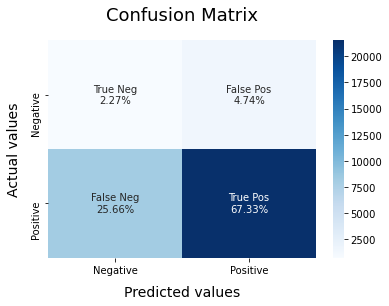

In [15]:
Evaluate(y_test1,y_pred1)

In [16]:
df2

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
...,...,...,...
99984,99996,0,@Cupcake seems like a repeating problem hop...
99985,99997,1,@cupcake__ arrrr we both replied to each other...
99986,99998,0,@CuPcAkE_2120 ya i thought so
99987,99999,1,@Cupcake_Dollie Yes. Yes. I'm glad you had mor...


In [17]:
text2 = list(df2.SentimentText)
y_test2 = list(df2.Sentiment)

vectoriser, LRmodel = load_models()
    
df2 = predict(vectoriser, LRmodel, text2)
print(df2.head())

                                                text  sentiment
0                       is so sad for my APL frie...          0
1                     I missed the New Moon trail...          1
2                            omg its already 7:30 :O          0
3            .. Omgaga. Im sooo  im gunna CRy. I'...          0
4           i think mi bf is cheating on me!!!   ...          0


              precision    recall  f1-score   support

           0       0.86      0.78      0.82     43532
           1       0.84      0.90      0.87     56457

    accuracy                           0.85     99989
   macro avg       0.85      0.84      0.85     99989
weighted avg       0.85      0.85      0.85     99989



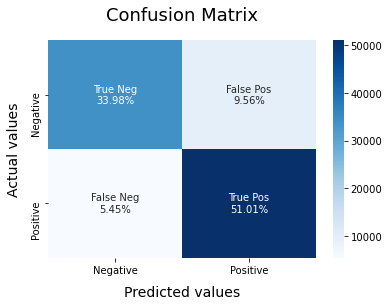

In [18]:
y_pred2 = list(df2.sentiment)
Evaluate(y_test2,y_pred2)

In [19]:
df3

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,4,@Covergirl08 I take pride in what I do
159998,4,heading to work on the 6


In [20]:

df3.sentiment_label[df3['sentiment_label']==4]=1

<ipython-input-20-854ee73ada90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sentiment_label[df3['sentiment_label']==4]=1


In [21]:
text3 = list(df3.tweet_text)
y_test3 = list(df3.sentiment_label)

vectoriser, LRmodel = load_models()
    
df3 = predict(vectoriser, LRmodel, text3)
print(df3.head())

                                                text  sentiment
0  @elephantbird Hey dear, Happy Friday to You  A...          1
1  Ughhh layin downnnn    Waiting for zeina to co...          1
2  @greeniebach I reckon he'll play, even if he's...          0
3              @vaLewee I know!  Saw it on the news!          1
4  very sad that http://www.fabchannel.com/ has c...          0


              precision    recall  f1-score   support

           0       0.86      0.86      0.86     80000
           1       0.86      0.86      0.86     80000

    accuracy                           0.86    160000
   macro avg       0.86      0.86      0.86    160000
weighted avg       0.86      0.86      0.86    160000



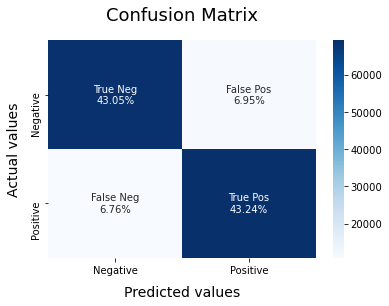

In [22]:
y_pred3 = list(df3.sentiment)
Evaluate(y_test3,y_pred3)